# 1D CNN on ECG data with transfer learning

This notebook demonstrates a 1D CNN that is trained on ECG data from the MIT-BIH dataset. This project will utilize transfer learning to learn the general patterns of an ECG. Then this final layers of this pre-trained model are re-trained on one specific patient using the first ten minutes of the ECG trace. Then the model will be evaluated using the final 20 minutes of the ECG trace.

Of course the to-be evaluated patient is not included initial learning step, this will prevent any data leakage. The process will be repeated in a leave-one-out-cross-validation fashion.

In [1]:
import math
import os
import tensorflow_addons as tfa
import datetime
import pandas as pd
import keras
import tensorflow as tf
import numpy as np
from keras.callbacks import Callback
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from scikitplot.metrics import plot_confusion_matrix, plot_roc

## Final filtering and loading
The dataset needs to have it's final preprocessing steps applied. 
We factorize the labels (convert strings to integers) so it can be used by the model.
Also we exclude any hearthbeats that have a windown length of 160, these are hearthbeats that occur in the beginning and and of a recording

In [2]:
data = pd.read_pickle("splitted_samples.data")

data = data[data['waves'].str.len() == 160]
# factorize labels
factorized_labels = data["beat_type"].factorize()
data["label"] = factorized_labels[0]

In [3]:
summ = data["beat_type"].value_counts()
print("Percentage of normal hearthbeats")
1- (sum(summ) - summ["N"]) / sum(summ)

Percentage of normal hearthbeats


0.6856484950382865

## Data splitting and normalization
Data needs to be splitted and transformed to the correct shape. Then the values are normalized between 0 and 1. It is important to note that that test and train data is seperately normalized, also the two hearth tracks are also seperately normalized

In [4]:
def train_test_split():
    patient_count = np.unique(data["patient"]).shape[0]
    
    for i in range(patient_count):
        train = data[data["patient"] != i]
        test = data[data["patient"] == i]

        train_data, train_labels = np.array(train["waves"].tolist()), np.expand_dims(train["label"].values, axis=1)
        test_data, test_labels = np.array(test["waves"].tolist()), np.expand_dims(test["label"].values, axis=1)
        
        # Normalization between [0,1]
        train_data[:,:,0] = (train_data[:,:,0] - train_data[:,:,0].min()) / (train_data[:,:,0].max() - train_data[:,:,0].min())
        train_data[:,:,1] = (train_data[:,:,1] - train_data[:,:,1].min()) / (train_data[:,:,1].max() - train_data[:,:,1].min())  
        
        test_data[:,:,0] = (test_data[:,:,0] - test_data[:,:,0].min()) / (test_data[:,:,0].max() - test_data[:,:,0].min())  
        test_data[:,:,1] = (test_data[:,:,1] - test_data[:,:,1].min()) / (test_data[:,:,1].max() - test_data[:,:,1].min())  

        yield (train_data, train_labels), (test_data, test_labels)

## Evaluation all models with cross validation

In [28]:
class PerformanceVisualizationCallback(Callback):
        def __init__(self, model, validation_data, image_dir):
            super().__init__()
            self.model = model
            self.validation_data = validation_data
        
            os.makedirs(image_dir, exist_ok=True)
            self.image_dir = image_dir

        def on_epoch_end(self, epoch, logs={}):
            y_pred = np.asarray(self.model.predict(self.validation_data[0]))
            y_true = self.validation_data[1]             
            y_pred_class = np.argmax(y_pred, axis=1)

            # plot and save confusion matrix
            fig, ax = plt.subplots(figsize=(16,12))
            plot_confusion_matrix(y_true, y_pred_class, ax=ax)
            fig.savefig(os.path.join(self.image_dir, f'confusion_matrix_epoch_{epoch}'))

Enter name of run a


Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_57_input (InputLayer) [(None, 160, 2)]          0         
_________________________________________________________________
conv1d_57 (Conv1D)           (None, 158, 16)           112       
_________________________________________________________________
max_pooling1d_57 (MaxPooling (None, 79, 16)            0         
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 77, 32)            1568      
_________________________________________________________________
max_pooling1d_58 (MaxPooling (None, 38, 32)            0         
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 36, 64)            6208      
_________________________________________________________________
max_pooling1d_59 (MaxPooling (None, 18, 64)            0  

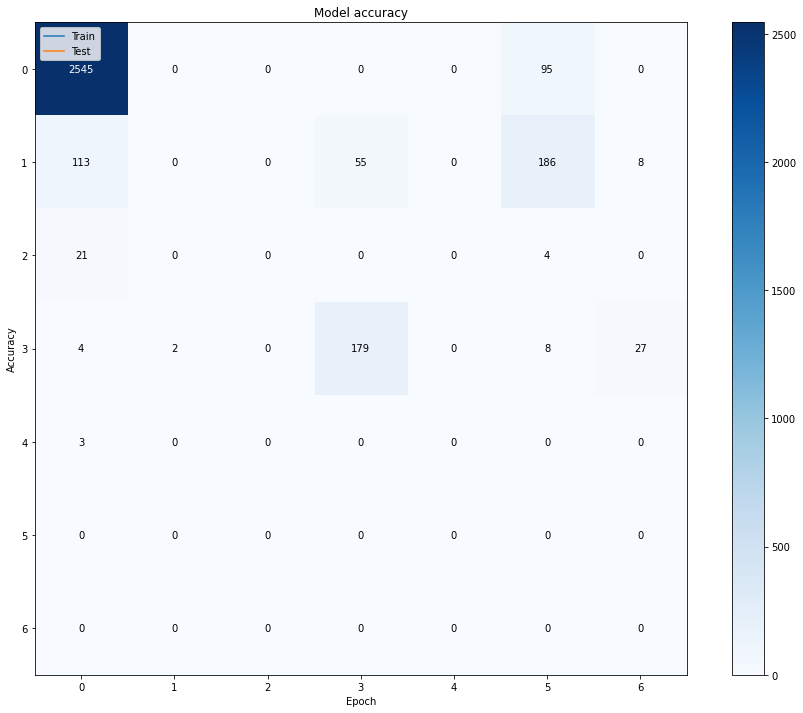

In [29]:
patient = 0
run_name = input("Enter name of run")


for (train_data, train_labels), (test_data, test_labels) in train_test_split():

    base_model = models.Sequential()
    base_model.add(layers.Conv1D(16, 3, input_shape=(160, 2), activation="relu"))
    base_model.add(layers.MaxPool1D(2))
    base_model.add(layers.Conv1D(32, 3, activation="relu"))
    base_model.add(layers.MaxPool1D(2))
    base_model.add(layers.Conv1D(64, 3, activation="relu"))
    base_model.add(layers.MaxPool1D(2))

    final_layers = base_model.output
    final_layers = layers.Flatten()(final_layers)
    final_layers = layers.Dense(32, activation="relu")(final_layers)
    final_layers = layers.Dense(14, activation="relu")(final_layers)

    model = tf.keras.models.Model(inputs=base_model.input, outputs=final_layers)
    model.summary()

    # ---------------

    model.compile(optimizer="adam",
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=["accuracy"])

    print("First training step")
    history = model.fit(train_data, train_labels, epochs=2)
    
    #performance_cbk = PerformanceVisualizationCallback(model=model, validation_data=(test_data, test_labels),image_dir='performance_vizualizations')
    #history = model.fit(train_data,train_labels,epochs=1,validation_data=(test_data, test_labels),callbacks=[performance_cbk])

    for layer in model.layers[:len(base_model.layers)+1]:
        layer.trainable = False
    base_model_weights = model.layers[0].get_weights()

    # we now use test data for training
    split = math.floor(test_data.shape[0] * 1/3)
    transfer_train_data = test_data[:split]
    transfer_train_labels = test_labels[:split]
    transfer_validation_data = test_data[split:]
    transfer_validation_labels = test_labels[split:]

    log_dir = "logs/fit/" + run_name + "patient " + str(patient) + " | " + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    print("Second training step")
    # model.fit(transfer_train_data, transfer_train_labels, validation_data=(transfer_validation_data, transfer_validation_labels), epochs=5,callbacks=[tensorboard_callback])
    
    # Fitting the model and creating the confusion matrix
    performance_cbk = PerformanceVisualizationCallback(
                      model=model,
                      validation_data=(test_data, test_labels),
                      image_dir='performance_vizualizations')
    
    history = model.fit(train_data,
                    train_labels,
                    epochs=2,
                    validation_data=(test_data, test_labels),
                    callbacks=[performance_cbk])
    
    # Plotting the confusion matrix
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    # tf.keras.backend.clear_session()
    break
    patient += 1

In [67]:
np.testing.assert_allclose(model.layers[0].get_weights(), base_model_weights)

In [51]:
model.layers[:len(base_model.layers)+1]